# Predicting house prices project, feature engineering notebook

In this notebook I will perform some operations on the data, following the preliminary data cleaning and work on non-numerical variables of the pthp_data notebook. The goal is reduce the dimensionality of the model input, by selecting a subset of most-significant variables or by combning them into ad-hoc features.  
For this purpose I've used the following techniques:  

1. indentification of variables correlated with the target;
2. identification of highly correlated variables;
3. principle component analysis;
4. backwards elimination, or recursive feature elimination;
5. LassoCV, i.e. an iterative method that fits the model on a regularisation path. Basically build models with different variables each iteration.

In each case I am saving a version of the engineered training set, so that I can easily compare them during model evaluation.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import pickle

%matplotlib inline

### Importing data

In [70]:
feat = pd.read_csv('data/Features_xy.csv')
feat = feat.drop('Unnamed: 0',axis=1)
feat.shape

(1021, 87)

In [89]:
test_feat = pd.read_csv('data/Test_Features_xy.csv')
test_feat = test_feat.drop('Unnamed: 0',axis=1)
test_feat.shape

(439, 85)

## 1. Checking correlation between variables and target

I can check the Pearson correlation between the predicting variables and the target to discard weakly correlated variables and make my model simpler. As a discriminating value, I am choosing 0.5.

In [36]:
corr_mat =feat.corr()
#Correlation with output variable
cor_target = abs(corr_mat["SalePrice"])#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

OverallQual     0.796643
YearBuilt       0.529300
YearRemodAdd    0.528340
ExterQual       0.696602
BsmtQual        0.585119
TotalBsmtSF     0.639615
1stFlrSF        0.623737
GrLivArea       0.734595
FullBath        0.557134
KitchenQual     0.670930
TotRmsAbvGrd    0.567864
FireplaceQu     0.545558
GarageFinish    0.556240
GarageCars      0.658604
GarageArea      0.648684
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [37]:
len(relevant_features)

16

I can now thus save a skimmed features table with only these selected variables.

In [16]:
feat_skimmed = feat[relevant_features.index.tolist()]

In [20]:
feat_skimmed.head()

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,FireplaceQu,GarageFinish,GarageCars,GarageArea,SalePrice
0,7,17,17,4,4,856,856,1710,2,4,8,0,2,2,548,208500
1,6,44,44,3,4,1262,1262,1262,2,3,6,3,2,2,460,181500
2,7,19,18,4,4,920,920,1786,2,4,6,3,2,2,608,223500
3,7,105,50,3,3,756,961,1717,1,4,7,4,1,3,642,140000
4,8,20,20,4,4,1145,1145,2198,2,4,9,3,2,3,836,250000


In [21]:
feat_skimmed.to_csv('data/Features_xy_skimmed.csv')

## 2. Checking correlations among predicting variables
For this check, I am going to isolate only redundant variables, with Pearson correlation > 0.8.

In [47]:
keep = []
toss=[]
for col_name in corr_mat.columns:
    cor_target = corr_mat[col_name]
    rel_feat = cor_target[cor_target>0.8]
    if len(rel_feat)>1:
        if rel_feat.index[0] not in keep and rel_feat.index[0] not in toss:
            keep.append(rel_feat.index[0])
        for i in range(1,len(rel_feat.index)):
            if rel_feat.index[i] not in toss and rel_feat.index[i] not in keep:
                toss.append(rel_feat.index[i])
        #print('Variables highly correlated with ',col_name)
        #print(rel_feat.index)
        
print('To keep: ', keep)
print('To toss: ', toss)

To keep:  ['YearBuilt', 'Exterior1st', 'TotalBsmtSF', 'GrLivArea', 'Fireplaces', 'GarageCars', 'GarageQual', 'MiscVal', 'New']
To toss:  ['GarageYrBlt', 'Exterior2nd', '1stFlrSF', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageArea', 'GarageCond', 'Gar2', 'Partial']


Removing the redundant variables:

In [50]:
feat_drop_corr_var = feat.drop(toss, axis=1)
feat_drop_corr_var.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SalePrice,Distance_from_centre,Othr,Shed,New,Abnorml,AdjLand,Alloca,Family,Normal
0,60,6,65.0,8450,2,0,0,0,0,0,...,208500,2.755615,0,0,0.0,0,0,0,0,1
1,20,6,80.0,9600,2,0,0,0,0,3,...,181500,3.044544,0,0,0.0,0,0,0,0,1
2,60,6,68.0,11250,2,0,1,0,0,0,...,223500,2.755615,0,0,0.0,0,0,0,0,1
3,70,6,60.0,9550,2,0,1,0,0,1,...,140000,0.865635,0,0,0.0,1,0,0,0,0
4,60,6,84.0,14260,2,0,1,0,0,3,...,250000,4.832330,0,0,0.0,0,0,0,0,1


In [52]:
feat_drop_corr_var.to_csv('data/Features_xy_corr_drop.csv')

## 3. PCA
Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors (each being a linear combination of the variables and containing n observations) are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables. (_from Wikipedia_)

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [7]:
feat = pd.read_csv('data/Features_xy.csv')
feat = feat.drop('Unnamed: 0',axis=1)
X = feat.drop(['Neighborhood','SalePrice'],axis=1)

scaler = MinMaxScaler()
X_rescaled = scaler.fit_transform(X)

reference: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

In [8]:
X_rescaled = np.nan_to_num(X_rescaled, nan=0.0, posinf=None, neginf=None)

pca = PCA(n_components = 0.95)
pca.fit(X_rescaled)
reduced = pca.transform(X_rescaled)

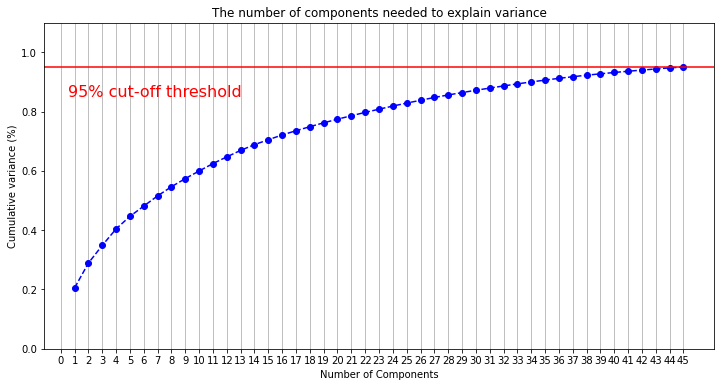

In [9]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(y)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(y)+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In this case, I need 45 components to retain 95% of the variance.

### Feature space transformation

In [10]:
p_h_p_pca = PCA(n_components = 45)

In [11]:
X_rescaled.shape

(1021, 85)

In [12]:
p_h_p_pca.fit(X_rescaled)

PCA(copy=True, iterated_power='auto', n_components=45, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [13]:
p_h_p_pca.components_ #gives eigenvectors

array([[-4.42989338e-03, -6.92735787e-02,  1.90232159e-02, ...,
        -2.95845018e-03, -1.17076987e-01,  1.78619089e-01],
       [ 2.18462895e-03, -3.08855827e-02,  2.84264876e-02, ...,
         2.90682883e-02, -6.32624008e-01,  3.86937992e-01],
       [ 1.04820415e-01, -3.79278355e-02, -3.46391904e-02, ...,
        -4.27473626e-04, -1.30086757e-01,  3.17924795e-02],
       ...,
       [ 2.65961577e-01, -2.66248790e-01,  1.55191398e-01, ...,
         3.10572465e-01,  2.46191370e-02,  2.87923528e-03],
       [-6.71871900e-02, -8.74436729e-02,  1.00290865e-01, ...,
        -6.82629739e-02, -2.49780032e-02, -4.46435556e-02],
       [-2.26647131e-02, -3.66856076e-02, -1.13362290e-01, ...,
        -3.43401032e-01, -8.56620645e-02, -5.19235213e-02]])

In [124]:
Z_feat = p_h_p_pca.transform(X_rescaled)

In [125]:
Z_feat.shape

(1021, 45)

### Saving the PCA feature space

In [14]:
# save the PCA model to disk
filename = 'models/pthp_pca.sav'
pickle.dump(p_h_p_pca, open(filename, 'wb'))

In [129]:
np.savetxt('data/Feature_x_PCA.csv',Z_feat,delimiter=',')
y = feat['SalePrice']
y.to_csv('data/train_y.csv')

# Backwards elimination and recursive feature elimination (RFE)

In this case we use a fitting ML model (such as linear regression) and we remove the variables with smaller coefficients, or lower influence on the predicted value, as measured by a suitable metric.
Reference: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

## 4a. Backward elimination

We feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

from reference: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b.

In [172]:
import statsmodels.api as sm

### Data import and normalisation

In [173]:
feat = pd.read_csv('data/Features_xy.csv')
feat = feat.drop('Unnamed: 0',axis=1)
feat = feat.dropna()
X = feat.drop(['Neighborhood','SalePrice'],axis=1)
y = feat['SalePrice']

#scaler = MinMaxScaler()
#X_rescaled = scaler.fit_transform(X)
#X_rescaled = np.nan_to_num(X_rescaled, nan=0.0, posinf=None, neginf=None)

In [174]:
X.shape

(957, 85)

In [175]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['MSSubClass', 'LotFrontage', 'LotArea', 'Condition2', 'OverallQual', 'OverallCond', 'YearBuilt', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageArea', 'ScreenPorch', 'PoolQC', 'New', 'Abnorml']


In [176]:
BE_feat = X[selected_features_BE]
BE_feat.to_csv('data/BE_feat_x.csv')
y.to_csv('data/BE_train_y.csv')

In [177]:
BE_feat.shape

(957, 29)

### Test data

In [1]:
selected_features_BE=['MSSubClass', 'LotFrontage', 'LotArea', 'Condition2', 'OverallQual', 'OverallCond', 'YearBuilt', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageArea', 'ScreenPorch', 'PoolQC', 'New', 'Abnorml']

In [5]:
test_feat = pd.read_csv('data/Test_Features_xy.csv')
test_feat = test_feat.drop('Unnamed: 0',axis=1)
X_test_BE = test_feat[selected_features_BE]
X_test_BE.to_csv('data/X_test_BE.csv')
X_test_BE.shape

(439, 29)

## 4b. RFE


In [84]:
feat = pd.read_csv('data/Features_xy.csv')
feat = feat.drop('Unnamed: 0',axis=1)
X = feat.drop(['Neighborhood','SalePrice'],axis=1)
y = feat['SalePrice']
scaler = MinMaxScaler()
X_rescaled = scaler.fit_transform(X)
X_rescaled = np.nan_to_num(X_rescaled, nan=0.0, posinf=None, neginf=None)

In [92]:
test_feat = pd.read_csv('data/Test_Features_xy.csv')
test_feat = test_feat.drop('Unnamed: 0',axis=1)
X_test_feat = test_feat.drop(['Neighborhood'],axis=1)
#y_test_feat = test_feat['SalePrice']
test_scaler = MinMaxScaler()
X_test_rescaled = test_scaler.fit_transform(X_test_feat)
X_test_rescaled = np.nan_to_num(X_test_rescaled, nan=0.0, posinf=None, neginf=None)

X_rescaled.shape[1]

Now I cannot use the test data, as it is not provided with the target column, hence I will use the train data to optimise the model to perform RFE.

In [96]:
#no of features
nof_list=np.arange(1,X_rescaled.shape[1])            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X_rescaled,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("R^2 score with %d features: %f" % (nof, high_score))

Optimum number of features: 13
R^2 score with 13 features: 0.762878


Awesome, but which features?

In [97]:
cols = list(X.columns)
model = LinearRegression()#Initializing RFE model
rfe = RFE(model, 13)             #Transforming data using RFE
X_rfe = rfe.fit_transform(X_rescaled,y)  #Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['LotArea', 'Condition2', 'OverallQual', 'RoofMatl', 'ExterQual',
       'BsmtFinSF1', '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageArea', 'PoolQC'],
      dtype='object')


### RFE - saving features data

In [115]:
feat_rfe = feat[selected_features_rfe]
feat_rfe['SalePrice'] = feat['SalePrice']
feat_rfe.head()

C:\Users\raffa\anaconda3\envs\py3_TF2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,LotArea,Condition2,OverallQual,RoofMatl,ExterQual,BsmtFinSF1,1stFlrSF,2ndFlrSF,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageArea,PoolQC,SalePrice
0,8450,0,7,3,4,706,856,854,3,1,8,548,0,208500
1,9600,0,6,3,3,978,1262,0,3,1,6,460,0,181500
2,11250,0,7,3,4,486,920,866,3,1,6,608,0,223500
3,9550,0,7,3,3,216,961,756,3,1,7,642,0,140000
4,14260,0,8,3,4,655,1145,1053,4,1,9,836,0,250000


In [116]:
feat_rfe.to_csv('data/Features_xy_RFE.csv')

In [154]:
feat_rfe.shape

(1021, 14)

## 5. LassoCV

Reference: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b.

In [178]:
feat = pd.read_csv('data/Features_xy.csv')
feat = feat.drop('Unnamed: 0',axis=1)
feat = feat.dropna()

X = feat.drop(['Neighborhood','SalePrice'],axis=1)
y = feat['SalePrice']

In [179]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 237469.165653
Best score using built-in LassoCV: 0.761401


In [180]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 13 variables and eliminated the other 72 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

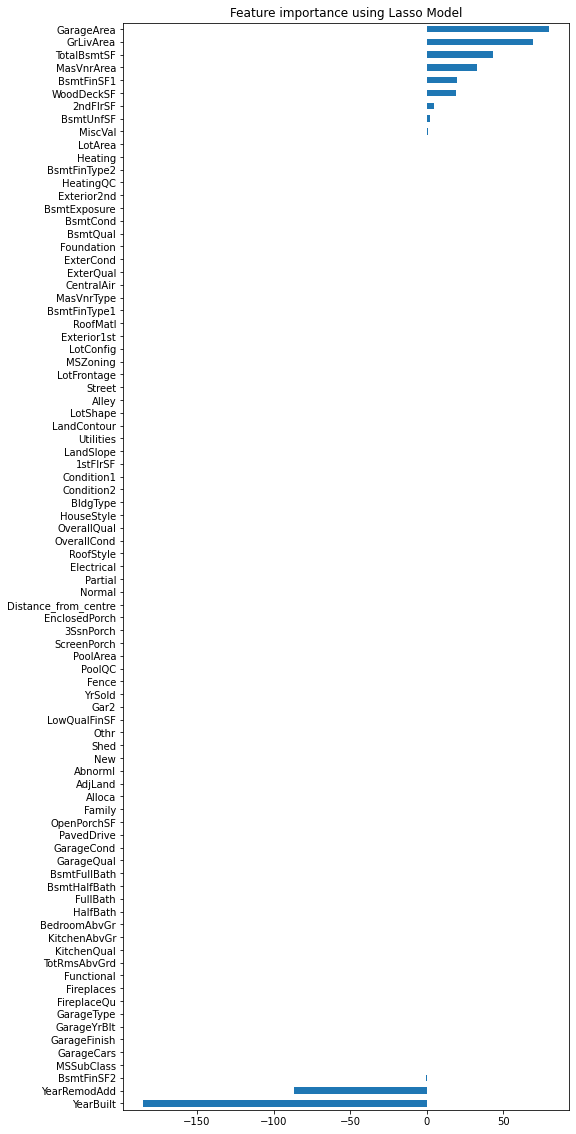

In [181]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 20.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [170]:
var_to_keep = coef.index[coef!=0].tolist()

In [182]:
lassoCV_X = X[var_to_keep]
lassoCV_X.to_csv('data/LassoCV_feat_X.csv')
y.to_csv('data/LassoCV_train_y.csv')